In [2]:
import numpy as np
import nibabel as nib
import random
import matplotlib.pyplot as plt
import glob
import splitfolders
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [1]:
from keras.layers import (
    Input, 
    Conv3D, 
    MaxPooling3D, 
    concatenate, 
    Conv3DTranspose, 
    Dropout, 
    Activation
)
from keras.models import Model


kernel_initializer =  'he_uniform' #Try others if you want
 
################################################################

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS,
num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH,
IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No needfor this if we normalize our inputs beforehand
    s = inputs
 
    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu',kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
 
    c2 = Conv3D(32, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
 
    c3 = Conv3D(64, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
 
    c4 = Conv3D(128, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
 
    c5 = Conv3D(256, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c5)
 
    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2),
padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c6)
 
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2),
padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c7)
 
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2),
padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c8)
 
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2),
padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu',
kernel_initializer=kernel_initializer, padding='same')(c9)
 
    outputs = Conv3D(num_classes, (1, 1, 1),
activation='softmax')(c9)
 
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()
 
    return model
 
#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 4, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 128, 4)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d (Conv3D)               │ (None, 128, 128, 128, 16) │           1,744 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128, 128, 128, 16) │               0 │ conv3d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_1 (Conv3D)             │ (None, 128, 128, 128, 16) │           6,928 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d (MaxPooling3D)  │ (None, 64, 64, 64, 16)    │               0 │ conv3d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_2 (Conv3D)             │ (None, 64, 64, 64, 32)    │          13,856 │ max_pooling3d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64, 64, 64, 32)    │               0 │ conv3d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 64, 64, 64, 32)    │          27,680 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_1               │ (None, 32, 32, 32, 32)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 32, 32, 32, 64)    │          55,360 │ max_pooling3d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 32, 64)    │               0 │ conv3d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 32, 32, 32, 64)    │         110,656 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 16, 16, 16, 64)    │               0 │ conv3d_5[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 16, 16, 16, 128)   │         221,312 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 16, 16, 16, 128)   │               0 │ conv3d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 16, 16, 16, 128)   │         442,496 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


In [3]:
def extract_patch(image, mask, patch_size):
    img_shape = image.shape[:3]
    patch_x = np.random.randint(0, max(img_shape[0] - patch_size[0], 1))
    patch_y = np.random.randint(0, max(img_shape[1] - patch_size[1], 1))
    patch_z = np.random.randint(0, max(img_shape[2] - patch_size[2], 1))
   
    return (
        image[patch_x:patch_x + patch_size[0], patch_y:patch_y + patch_size[1], patch_z:patch_z + patch_size[2], :],
        mask[patch_x:patch_x + patch_size[0], patch_y:patch_y + patch_size[1], patch_z:patch_z + patch_size[2]])

In [4]:
def gamma_correction(image, gamma):
    return np.clip(image ** gamma, 0, 1)

def augment_image(image, mask, is_training=True):
    if is_training:
        # Rotation
        angle = np.random.uniform(-15, 15)
        image = rotate(image, angle, axes=(0, 1), reshape=False, mode='reflect')
        mask = rotate(mask, angle, axes=(0, 1), reshape=False, mode='reflect')
        
        # Flipping
        if np.random.rand() > 0.5:
            image, mask = np.flip(image, axis=0), np.flip(mask, axis=0)
        if np.random.rand() > 0.5:
            image, mask = np.flip(image, axis=1), np.flip(mask, axis=1)
     
        # Brightness Adjustment
        brightness = np.random.uniform(0.9, 1.1)
        image = np.clip(image * brightness, 0, 1)

        # Noise Addition (Gaussian noise)
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)
     
        # Gamma Correction
        if np.random.rand() > 0.5:
            gamma = np.random.uniform(0.8, 1.2)
            image = gamma_correction(image, gamma)
            
    return image, mask

In [7]:
import numpy as np
import os
from scipy.ndimage import rotate

def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:
        if image_name.endswith('.npy'):
            try:
                image = np.load(os.path.join(img_dir, image_name), allow_pickle=True).astype(np.float32)
                images.append(image)
            except Exception as e:
                print(f"Error loading file {image_name}: {e}")
    return np.array(images) if images else np.array([])

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size, patch_size, is_training=True):
    L = len(img_list)
    while True:
        batch_start = 0
        while batch_start < L:
            batch_end = min(batch_start + batch_size, L)
            X = load_img(img_dir, img_list[batch_start:batch_end])
            Y = load_img(mask_dir, mask_list[batch_start:batch_end])
            
            if len(X) == 0 or len(Y) == 0:
                batch_start = batch_end
                continue
                
            X_patches, Y_patches = zip(*[augment_image(*extract_patch(img, mask, patch_size), is_training) 
                                       for img, mask in zip(X, Y)])
            
            yield np.stack(X_patches, axis=0), np.stack(Y_patches, axis=0)
            batch_start = batch_end

### phase 3: Training 

In [8]:
import tensorflow as tf

class DiceScore(tf.keras.metrics.Metric):
    def __init__(self, num_classes, class_weights=None, smooth=1e-6, **kwargs):
        super(DiceScore, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_weights = class_weights if class_weights is not None else tf.ones(num_classes) # Default to equal weights
        self.dice_scores = self.add_weight(name='dice_scores', shape=(self.num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten the tensors to ensure computations are class-wise
        y_true = tf.reshape(y_true, [-1]) # Flatten ground truth
        y_pred = tf.reshape(y_pred, [-1]) # Flatten predictions

        # Initialize the dice scores for each class
        dice_scores = []

        for i in range(self.num_classes):
            # Create binary masks for class i
            y_true_class = tf.cast(tf.equal(y_true, i), 'float32')
            y_pred_class = tf.cast(tf.equal(tf.round(y_pred), i), 'float32')

            # Calculate intersection and union
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)

            # Compute Dice score for the current class
            dice_class = (2. * intersection + self.smooth) / (union + self.smooth)

            # Apply class weight to the Dice score
            weighted_dice_class = dice_class * self.class_weights[i]
            dice_scores.append(weighted_dice_class)

        # Update state by averaging weighted dice scores across all classes
        dice_scores = tf.stack(dice_scores)
        self.dice_scores.assign(dice_scores)

    def result(self):
        # Return the mean of the weighted dice scores
        return tf.reduce_mean(self.dice_scores)

    def reset_states(self):
        # Reset the dice scores at the start of each batch
        self.dice_scores.assign(tf.zeros(self.num_classes))

## model training

In [9]:
# Set seeds for reproducibility
import random
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import time
import segmentation_models_3D as sm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import pandas as pd



start = time.time()
# Set up loss function with class weights
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
class_weights = np.array([wt0, wt1, wt2, wt3], dtype=np.float32)

dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = 0.2 * dice_loss + 0.2 * focal_loss # focal loss of 0.2 (perf best now) becomes 0.1

# Define metrics
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), DiceScore(num_classes=4)]

# Learning rate scheduler (Cosine Decay)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5 # from 6 to 4(perf better) to 3
)

# Optimizer (use a fixed learning rate)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, clipnorm=1.0) #increase from 0.001(perf best) to 0.01

# Data paths
DATA_ROOT = "glioma split data"
train_img_dir, train_mask_dir = f"{DATA_ROOT}/train/images/", f"{DATA_ROOT}/train/masks/"
val_img_dir, val_mask_dir = f"{DATA_ROOT}/val/images/", f"{DATA_ROOT}/val/masks/"

# Load data
train_img_list, train_mask_list = os.listdir(train_img_dir), os.listdir(train_mask_dir)
val_img_list, val_mask_list = os.listdir(val_img_dir), os.listdir(val_mask_dir)

# Data generators
batch_size = 2
patch_size = (64, 64, 64)
train_data = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size, patch_size)
val_data = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size, patch_size)

# Training parameters
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size
epochs = 100

# Initialize and compile model
model = simple_unet_model(IMG_HEIGHT=64, IMG_WIDTH=64, IMG_DEPTH=64, IMG_CHANNELS=4, num_classes=4)
model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)
model.summary()

# Define callbacks
checkpoint_path = f"saved_model/3D_unet_{epochs}_epochs_{batch_size}_batch_patch_training.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), #increase patience from 10 to 20
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    lr_scheduler # Learning rate decay callback
]

# Train model
history = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks,
    verbose=1
)

# Save training history
history_df = pd.DataFrame(history.history)
os.makedirs("model_history", exist_ok=True)
history_df.to_csv("model_history/training_history.csv", index=False)
print("Training history and best model saved successfully.")

end = time.time()
exec_time = (end - start)/60
print(f'execution time is - {exec_time} minutes or {exec_time/60} hour')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 64, 4)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_19 (Conv3D)            │ (None, 64, 64, 64, 16)    │           1,744 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 64, 64, 64, 16)    │               0 │ conv3d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_20 (Conv3D)            │ (None, 64, 64, 64, 16)    │           6,928 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_4               │ (None, 32, 32, 32, 16)    │               0 │ conv3d_20[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_21 (Conv3D)            │ (None, 32, 32, 32, 32)    │          13,856 │ max_pooling3d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 32, 32, 32, 32)    │               0 │ conv3d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_22 (Conv3D)            │ (None, 32, 32, 32, 32)    │          27,680 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_5               │ (None, 16, 16, 16, 32)    │               0 │ conv3d_22[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_23 (Conv3D)            │ (None, 16, 16, 16, 64)    │          55,360 │ max_pooling3d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 16, 16, 16, 64)    │               0 │ conv3d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_24 (Conv3D)            │ (None, 16, 16, 16, 64)    │         110,656 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_6               │ (None, 8, 8, 8, 64)       │               0 │ conv3d_24[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_25 (Conv3D)            │ (None, 8, 8, 8, 128)      │         221,312 │ max_pooling3d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 8, 8, 8, 128)      │               0 │ conv3d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_26 (Conv3D)            │ (None, 8, 8, 8, 128)      │         442,49

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 64, 4)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_19 (Conv3D)            │ (None, 64, 64, 64, 16)    │           1,744 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 64, 64, 64, 16)    │               0 │ conv3d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_20 (Conv3D)            │ (None, 64, 64, 64, 16)    │           6,928 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_4               │ (None, 32, 32, 32, 16)    │               0 │ conv3d_20[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_21 (Conv3D)            │ (None, 32, 32, 32, 32)    │          13,856 │ max_pooling3d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 32, 32, 32, 32)    │               0 │ conv3d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_22 (Conv3D)            │ (None, 32, 32, 32, 32)    │          27,680 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_5               │ (None, 16, 16, 16, 32)    │               0 │ conv3d_22[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_23 (Conv3D)            │ (None, 16, 16, 16, 64)    │          55,360 │ max_pooling3d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 16, 16, 16, 64)    │               0 │ conv3d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_24 (Conv3D)            │ (None, 16, 16, 16, 64)    │         110,656 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_6               │ (None, 8, 8, 8, 64)       │               0 │ conv3d_24[0][0]            │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_25 (Conv3D)            │ (None, 8, 8, 8, 128)      │         221,312 │ max_pooling3d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 8, 8, 8, 128)      │               0 │ conv3d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_26 (Conv3D)            │ (None, 8, 8, 8, 128)      │         442,49

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - accuracy: 0.7242 - dice_score_1: 0.8140 - iou_score: 0.1718 - loss: 0.1967 - val_accuracy: 0.8632 - val_dice_score_1: 0.7798 - val_iou_score: 0.1059 - val_loss: 0.1930 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.8638 - dice_score_1: 0.8779 - iou_score: 0.2327 - loss: 0.1897 - val_accuracy: 0.9030 - val_dice_score_1: 0.9021 - val_iou_score: 0.3681 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 239s 7s/step - accuracy: 0.8313 - dice_score_1: 0.8664 - iou_score: 0.2354 - loss: 0.1887 - val_accuracy: 0.8566 - val_dice_score_1: 0.8753 - val_iou_score: 0.3138 - val_loss: 0.1890 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 224s 7s/step - accuracy: 0.8478 - dice_score_1: 0.8779 - iou_score: 0.2675 - loss: 0.1876 - val_accuracy: 0.6715 - val_dice_score_1: 0.8004 - val_iou_score: 0.3307 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 5/100
33/3

In [10]:
import os
import numpy as np
from keras.models import load_model
from keras.metrics import MeanIoU
from matplotlib import pyplot as plt


# -------------------- MODEL LOADING --------------------
# Path to trained model
model_path = 'saved_model/3D_unet_100_epochs_2_batch_patch_training.keras'

# Load the trained model without recompiling (for inference only)
try:
    my_model = load_model(model_path, compile=False)
except Exception as e:
    raise ValueError(f"Error loading model from {model_path}: {str(e)}")

# -------------------- DATA LOADING --------------------
# Path to dataset (Modify as needed)
DATA_PATH = "glioma split data"

# Validate directories exist
def validate_dir(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Directory not found: {path}")

# Train and Validation Directories
train_img_dir = os.path.join(DATA_PATH, "train/images/")
train_mask_dir = os.path.join(DATA_PATH, "train/masks/")
val_img_dir = os.path.join(DATA_PATH, "val/images/")
val_mask_dir = os.path.join(DATA_PATH, "val/masks/")
test_img_dir = os.path.join(DATA_PATH, "test/images/")
test_mask_dir = os.path.join(DATA_PATH, "test/masks/")

# Validate all directories
for dir_path in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, test_img_dir, test_mask_dir]:
    validate_dir(dir_path)

# Get sorted list of images and masks to ensure alignment
def get_sorted_files(directory):
    return sorted([f for f in os.listdir(directory) if f.endswith('.npy')])

train_img_list = get_sorted_files(train_img_dir)
train_mask_list = get_sorted_files(train_mask_dir)
val_img_list = get_sorted_files(val_img_dir)
val_mask_list = get_sorted_files(val_mask_dir)
test_img_list = get_sorted_files(test_img_dir)
test_mask_list = get_sorted_files(test_mask_dir)

# Define patch and batch size
patch_size = (64, 64, 64)
batch_size = 2

# -------------------- EVALUATION UTILITIES --------------------
def evaluate_stochastic(model, data_loader, n_batches=10):
    iou_metric = MeanIoU(num_classes=4)
    dice_metric = DiceScore(num_classes=4)
    
    for _ in range(n_batches):
        try:
            X, Y = next(data_loader)
            pred = model.predict(X, verbose=0)  # Disable prediction logging
            pred_argmax = np.argmax(pred, axis=-1)
            mask_argmax = np.argmax(Y, axis=-1)
            
            iou_metric.update_state(mask_argmax, pred_argmax)
            dice_metric.update_state(mask_argmax, pred_argmax)
        except StopIteration:
            break  # In case we have fewer than n_batches
    
    return iou_metric.result().numpy(), dice_metric.result().numpy()

# -------------------- VALIDATION DATA EVALUATION --------------------
# Create Data Generator for validation set (with is_training=False)
val_img_loader = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, 
                           batch_size, patch_size, is_training=False)

# Evaluate multiple batches for more reliable metrics
val_iou, val_dice = evaluate_stochastic(my_model, val_img_loader, n_batches=10)
print(f"Validation Metrics - Mean IoU: {val_iou:.4f}, Dice Score: {val_dice:.4f}")

# -------------------- TEST DATA EVALUATION --------------------
# Create Data Generator for test set (with is_training=False)
test_img_loader = imageLoader(test_img_dir, test_img_list, test_mask_dir, test_mask_list,
                            batch_size, patch_size, is_training=False)

# Evaluate multiple batches for more reliable metrics
test_iou, test_dice = evaluate_stochastic(my_model, test_img_loader, n_batches=10)
print(f"Test Metrics - Mean IoU: {test_iou:.4f}, Dice Score: {test_dice:.4f}")

Validation Metrics - Mean IoU: 0.3496, Dice Score: 0.2452
Test Metrics - Mean IoU: 0.4679, Dice Score: 0.4318


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


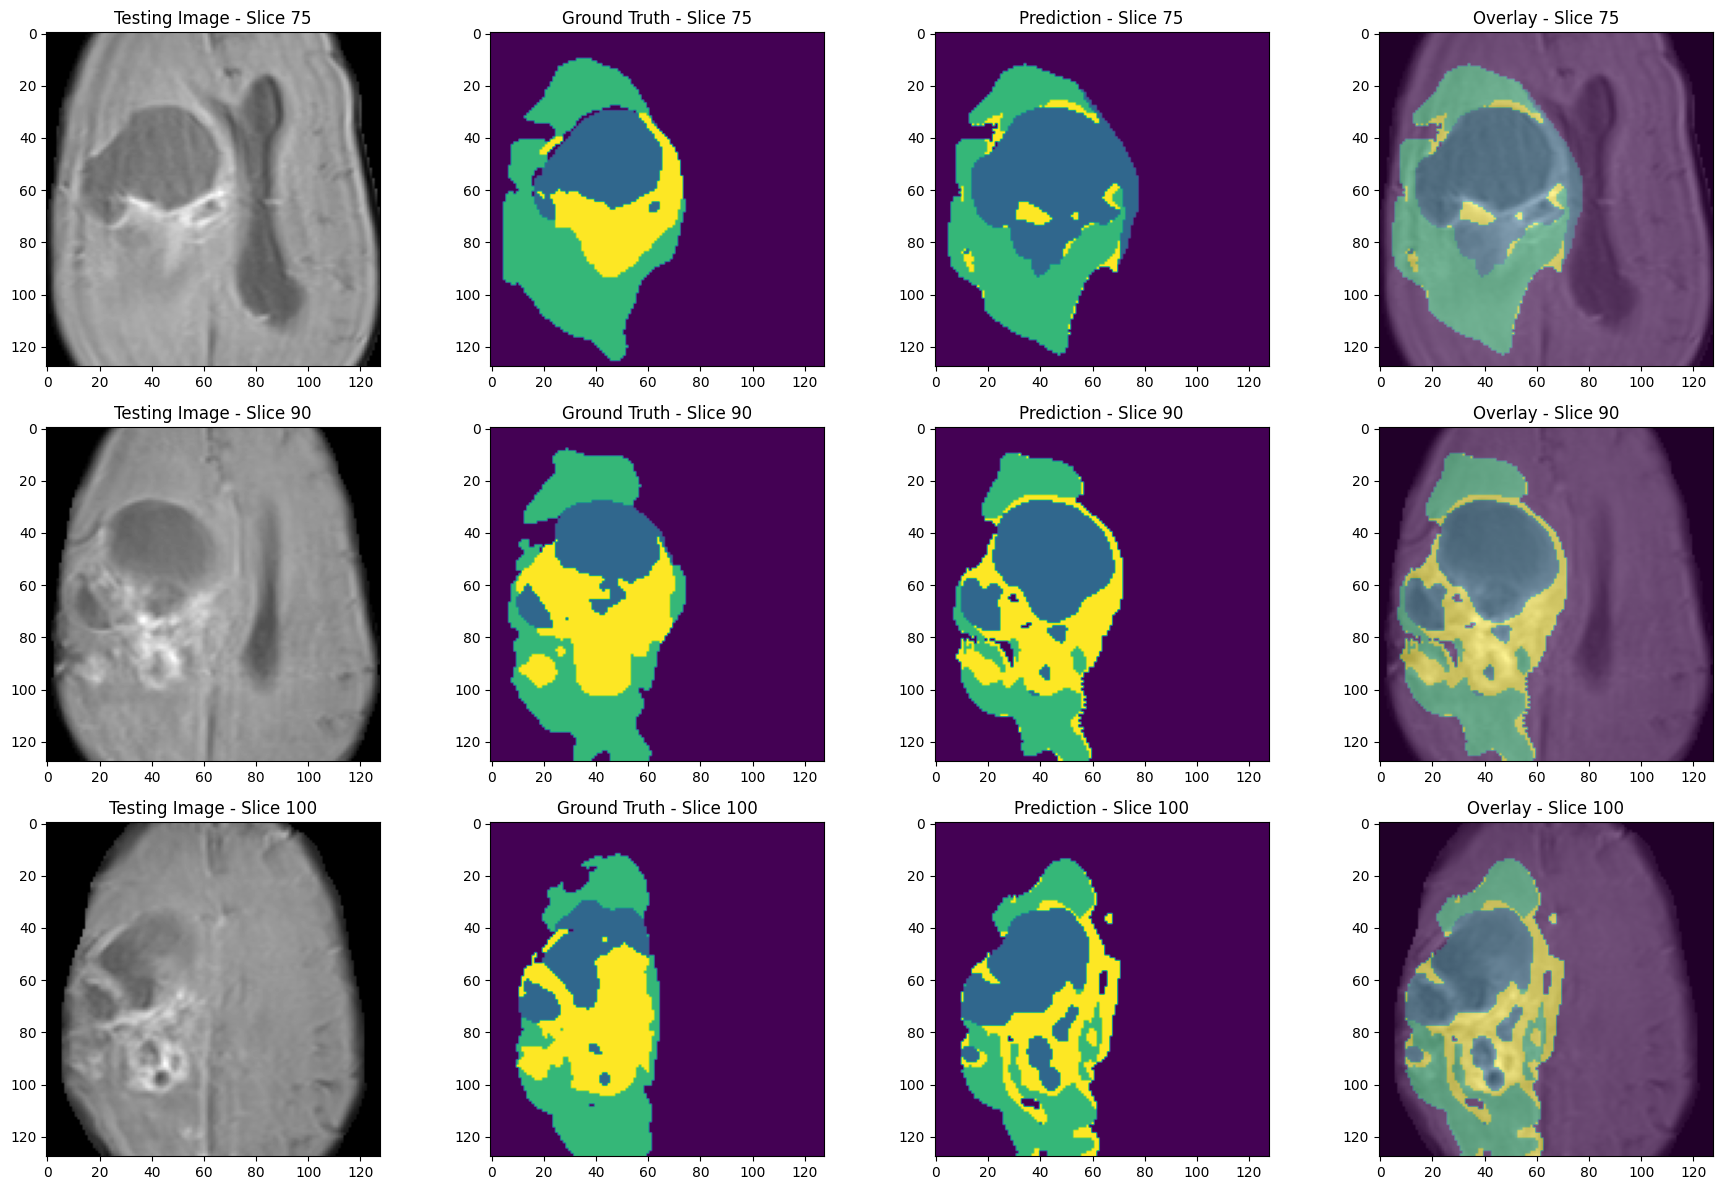

In [11]:
#-------------------- VISUALIZATION --------------------
# Select a random test image for visualization
img_num = 21  # Change index as needed
test_img = np.load(os.path.join(test_img_dir, f"image_{img_num}.npy"))
test_mask = np.load(os.path.join(test_mask_dir, f"mask_{img_num}.npy"))
test_mask_argmax = np.argmax(test_mask, axis=3)
 
# Expand dimensions for model prediction
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]
 
# Select slice indices for visualization
slice_indices = [75, 90, 100]  # Change slice indices as needed
 
# Plotting Results
plt.figure(figsize=(18,12))
 
for i, n_slice in enumerate(slice_indices):
 
  # Rotate images to correct orientation
 
  test_img_rotated = np.rot90(test_img[:, :, n_slice, 1])  #Rotating 90 degrees
 
  test_mask_rotated = np.rot90(test_mask_argmax[:, :, n_slice])
 
  test_prediction_rotated = np.rot90(test_prediction_argmax[:, :,
n_slice])
 
 
  # Plotting Results
 
  plt.subplot(3, 4, i*4 + 1)
 
  plt.title(f'Testing Image - Slice {n_slice}')
 
  plt.imshow(test_img_rotated, cmap='gray')
 
 
  plt.subplot(3, 4, i*4 + 2)
 
  plt.title(f'Ground Truth - Slice {n_slice}')
 
  plt.imshow(test_mask_rotated)
 
 
  plt.subplot(3, 4, i*4 + 3)
 
  plt.title(f'Prediction - Slice {n_slice}')
 
  plt.imshow(test_prediction_rotated)
 
 
  plt.subplot(3, 4, i*4 + 4)
 
  plt.title(f'Overlay - Slice {n_slice}')
 
  plt.imshow(test_img_rotated, cmap='gray')
 
  plt.imshow(test_prediction_rotated, alpha=0.5)  # Overlay prediction mask
 
plt.tight_layout()
plt.show()